In [71]:
import os 
import pandas as pd
import glob 
import seaborn as sns 
import matplotlib.pyplot as plt 
import numpy as np

os.chdir('/mnt/BioHome/jreyna/jreyna/projects/dchallenge/')

outdir = 'results/notebooks/colocalization_with_eqtl_catalogue/'
os.makedirs(outdir, exist_ok=True)

In [72]:
# load gwas meta-data
gwas_samplesheet = pd.read_table('config/gwas_samplesheets/gwas.samplesheet.tsv')
gwas_samplesheet.set_index('gwas_id', inplace=True)
gwas_samplesheet.index = gwas_samplesheet.index.str.replace('#', '')

## Loading the GENCODE Reference

In [73]:
gencode = pd.read_table('results/refs/gencode/v30/gencode.v30.annotation.bed', header=None)
gencode = gencode.iloc[:, [5,6]]
gencode.set_index(6, inplace=True)
gencode = gencode.squeeze()
gencode = gencode.to_dict()
rev_gencode = {v:k for k,v in gencode.items()}

## Loading and Processing the Colocalization Data 

In [74]:
major_cells = ['B-cell_naive', 'CD4_T-cell_naive',
               'CD8_T-cell_naive', 'NK-cell_naive','monocyte_naive']
major_gwas = ['T1D_32005708', 'T1D_34594039_GCST90018925', 'T1D_34012112_Gaulton', 'T1D_25751624']

In [75]:
data = []
eqtl_cat_glob = 'results/main/coloc/Results/eQTL_Catalogue/*/*/*/FINAL_Summary_Coloc_Gene_SNP_Pairs.bed'
eqtl_cat_glob = glob.glob(eqtl_cat_glob)
immunexut_glob = 'results/main/coloc/Results/ImmuNexUT/*/*/*/FINAL_Summary_Coloc_Gene_SNP_Pairs.bed'
immunexut_glob = glob.glob(immunexut_glob)
coloc_fns = sorted(eqtl_cat_glob + immunexut_glob) 
coloc_fns = [x for x in coloc_fns if 'test' not in x]
print('Number of colocalizations analyses: {}.'.format(len(coloc_fns)))

Number of colocalizations analyses: 167.


In [123]:
for fn in coloc_fns:
    
    # load the data
    df = pd.read_table(fn)
    
    # get GWAS, eQTL and gene expression sources
    fname_segs = fn.split('/')
    gwas = fname_segs[5]
    eqtl = fname_segs[6]
    ge = fname_segs[7]
    
    if gwas not in major_gwas:
        print('skipped gwas: {}'.format(gwas))
        continue 
        
    #     if ge not in major_cells:
    #         print('skipped ge:', ge)
    #         continue 

    #print('Processing: {}'.format(fn))
        
    # assign the current values
    df['gwas'] = gwas
    df['eqtl'] = eqtl
    df['ge'] = ge
    data.append(df)
    
t1d_data = pd.concat(data)

In [126]:
# add the gene name
t1d_data.geneName = t1d_data.geneName.str.replace('\.[0-9]*$', '', )
t1d_data['genename'] = t1d_data.geneName.replace(rev_gencode)

In [127]:
# removing duplicate SNP-gene pairs by find the one with the largest PP4
t1d_data_rgs = t1d_data.groupby(['gwas', 'eqtl', 'ge', 'rs_id', 'geneName'])
new_t1d_data = []
for grp, grp_df in t1d_data_rgs:
    max_index = np.argmax(grp_df.pp_H4_Coloc_Summary)
    new_t1d = grp_df.iloc[max_index,:]
    new_t1d_data.append(new_t1d)
new_t1d_data = pd.DataFrame(new_t1d_data)
new_t1d_data.reset_index(drop=True, inplace=True)

# assigning t1d_data to the new dataset
t1d_data = new_t1d_data.copy()

In [128]:
# creating a list of the most important columns 
major_cols = ['chr', 'pos','rs_id', 'variant_id', 'genename','pp_H4_Coloc_Summary', 'dist', 'pvalue', 'FDR', 'slope_snp',
       'slope_se_snp', 'slope_gwas', 'slope_se_gwas', 'pval_nominal', 'gwas', 'eqtl', 'ge',
       'geneName']

# generating a dataframe the the most important columns
t1d_data = t1d_data[major_cols]

# renaming these columns for easier understanding
major_renames = {
    'chr': 'chr',
    'pos': 'pos',
    'rs_id': 'rsid',
    'variant_id': 'varid',
    'genename': 'genename', 
    'pp_H4_Coloc_Summary': 'ppH4',
    'dist': 'sg_dist',
    'pvalue': 'eqtl_pval',
    'FDR': 'eqtl_fdr',
    'slope_snp': 'eqtl_slope',
    'slope_se_snp': 'eqtl_slope_se',
    'slope_gwas': 'gwas_slope',
    'slope_se_gwas': 'gwas_slope_se',
    'pval_nominal': 'gwas_pval',
    'SampleSize': 'gwas_sample_size',
    'gwas': 'gwas_source',
    'eqtl': 'eqtl_source',
    'ge': 'ge_source',
    'geneName': 'gene_id'}
major_cols = [major_renames[x] for x in major_cols]
t1d_data.rename(columns=major_renames, inplace=True)

### Checking Colocalized SNPs with Significant eQTLs (FDR<0.05)

In [129]:
sig_eqtls = t1d_data[major_cols].\
                        sort_values(['gwas_source', 'eqtl_source', 'ge_source', 'rsid']).\
                        set_index(['gwas_source', 'ge_source', 'rsid'])
sig_eqtls = sig_eqtls[sig_eqtls.eqtl_fdr < 0.05]

In [130]:
sig_eqtls

chr       pos  \
gwas_source               ge_source     rsid                          
T1D_25751624              T-cell        rs639575     chr6  90281412   
                          LCL           rs1788097   chr18  69876452   
                          T-cell        rs1788097   chr18  69876452   
                                        rs9981624   chr21  42405613   
                          LCL           rs1790932   chr18  69866164   
...                                                   ...       ...   
T1D_34012112_Gaulton      Tfh_memory    rs3825932   chr15  78943104   
                          Th1-17_memory rs1788105   chr18  69865056   
                          Treg_naive    rs3018275   chr18  69858621   
T1D_34594039_GCST90018925 pancreas      rs7755997    chr6  26482820   
                          CL_Mono       rs13217239   chr6  27287188   

                                                              varid  \
gwas_source               ge_source     rsid                          
T1D_25751624              T-cell        rs639575     6:90281412:A:T   
                          LCL           rs1788097   18:69876452:C:T   
                          T-cell        rs1788097   18:69876452:C:T   
                                        rs9981624   21:42405613:G:C   
                          LCL           rs1790932   18:69866164:C:T   
...                                                             ...   
T1D_34012112_Gaulton      Tfh_memory    rs3825932   15:78943104:T:C   
                          Th1-17_memory rs1788105   18:69865056:A:G   
                          Treg_naive    rs3018275   18:69858621:C:T   
T1D_34594039_GCST90018925 pancreas      rs7755997    6:26482820:G:A   
                          CL_Mono       rs13217239   6:27287188:T:C   

                                                      genename      ppH4  \
gwas_source               ge_source     rsid                               
T1D_25751624              T-cell        rs639575    AL132996.1  0.818894   
                          LCL           rs1788097         DOK6  0.818762   
                          T-cell        rs1788097         DOK6  0.777308   
                                        rs9981624      TMPRSS3  0.812207   
                          LCL           rs1790932         DOK6  0.849128   
...                                                        ...       ...   
T1D_34012112_Gaulton      Tfh_memory    rs3825932   AC027228.1  0.794168   
                          Th1-17_memory rs1788105   AC068254.1  0.842424   
                          Treg_naive    rs3018275         DOK6  0.841050   
T1D_34594039_GCST90018925 pancreas      rs7755997   AL513548.4  0.920109   
                          CL_Mono       rs13217239      BTN3A1  0.761549   

                                                    sg_dist     eqtl_pval  \
gwas_source               ge_source     rsid                                
T1D_25751624              T-cell        rs639575      39031  2.984650e-04   
                          LCL           rs1788097    475564  2.058970e-07   
                          T-cell        rs1788097    475564  1.302880e-14   
                                        rs9981624      8767  5.466630e-15   
                          LCL           rs1790932    465276  2.684030e-06   
...                                                     ...           ...   
T1D_34012112_Gaulton      Tfh_memory    rs3825932    461284  1.320460e-04   
                          Th1-17_memory rs1788105    140081  5.771950e-11   
                          Treg_naive    rs3018275    457733  1.243620e-07   
T1D_34594039_GCST90018925 pancreas      rs7755997    194183  1.681110e-10   
                          CL_Mono       rs13217239   884951  2.225530e-04   

                                                        eqtl_fdr  eqtl_slope  \
gwas_source               ge_source     rsid                                   
T1D_25751624              T-cell        rs639575    2.2

## Checking the Sources of Colocalized Datasets

In [131]:
check_sources = t1d_data.drop_duplicates(['gwas_source', 'eqtl_source', 'ge_source'])
check_sources = check_sources[['gwas_source', 'eqtl_source', 'ge_source']]

In [132]:
pd.set_option('display.max_rows', 100) 
display(check_sources.set_index(['gwas_source', 'eqtl_source']))
pd.set_option('display.max_rows', 20) 

ge_source
gwas_source               eqtl_source                        
T1D_25751624              BLUEPRINT                    T-cell
                          BLUEPRINT                  monocyte
                          BLUEPRINT                neutrophil
                          GENCORD                         LCL
                          GENCORD                      T-cell
...                                                       ...
T1D_34594039_GCST90018925 Schmiedel_2018           Tfh_memory
                          Schmiedel_2018          Th17_memory
                          Schmiedel_2018           Th1_memory
                          Schmiedel_2018           Th2_memory
                          Schmiedel_2018  monocyte_CD16_naive

[167 rows x 1 columns]

## Plotting the Number of SNP-Gene Pairs per Colocalization Analysis

In [133]:
study_summary = t1d_data.\
            value_counts(['gwas_source', 'eqtl_source', 'ge_source']).to_frame().reset_index().\
            sort_values(['gwas_source', 'eqtl_source', 'ge_source'])
study_summary.rename(columns={0:'count'}, inplace=True)

In [134]:
print('The median number of colocalizations per study is {}.'.format(study_summary['count'].median()))

The median number of colocalizations per study is 2.0.


In [135]:
study_summary.sort_values('count', ascending=False)

,gwas_source,eqtl_source,ge_source,count
1,T1D_34012112_Gaulton,ImmuNexUT,Fr_I_nTreg,7
0,T1D_34012112_Gaulton,ImmuNexUT,Plasmablast,7
2,T1D_34012112_Gaulton,Schmiedel_2018,Treg_naive,5
5,T1D_34012112_Gaulton,ImmuNexUT,NC_Mono,4
13,T1D_34012112_Gaulton,ImmuNexUT,CM_CD8,4
...,...,...,...,...
155,T1D_32005708,GTEx,blood,1
154,T1D_32005708,GTEx,LCL,1
153,T1D_32005708,BLUEPRINT,neutrophil,1
152,T1D_32005708,BLUEPRINT,monocyte,1


In [136]:
eqtl_colors = study_summary.eqtl_source.unique()
eqtl_colors = {k:v for k,v in zip(eqtl_colors, sns.color_palette(n_colors=len(eqtl_colors)))}

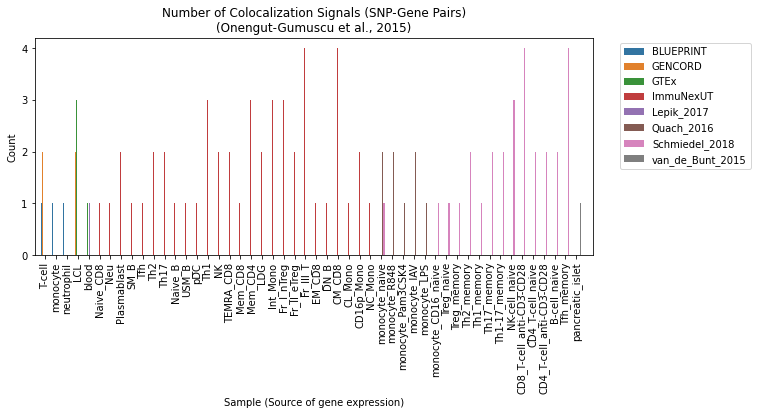

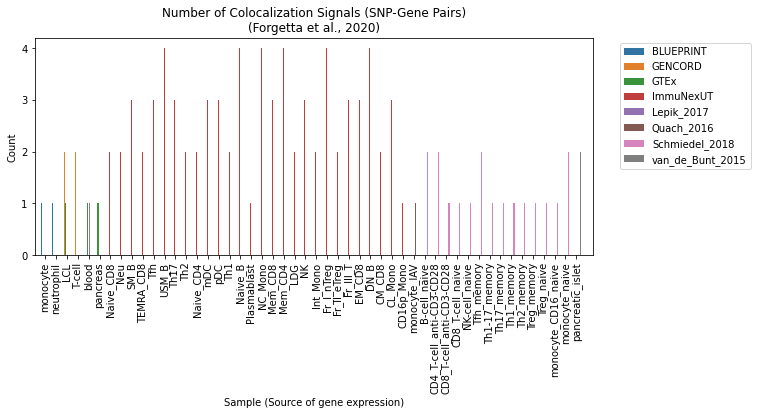

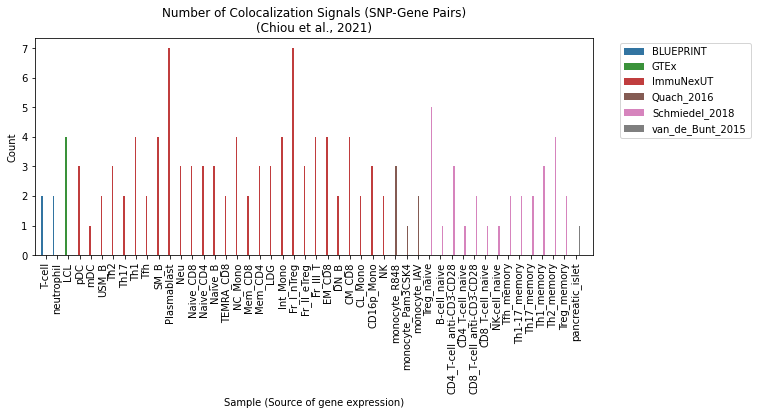

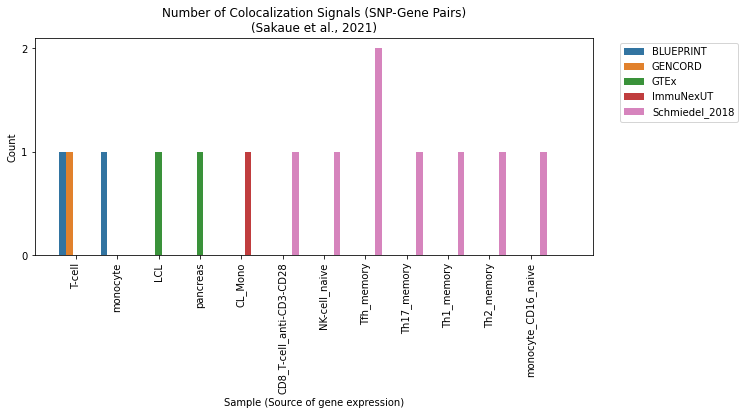

In [137]:
for gwas_source, gwas_summary in study_summary.groupby('gwas_source'):
        
    #sns.barplot(hue='eqtl', y='count', x='ge', data=study_summary)
    fig, ax = plt.subplots(figsize=(10,4))
    
    # Draw a nested barplot by species and sex
    gwas_summary.sort_values('eqtl_source', inplace=True)
    g = sns.barplot(data=gwas_summary,
                x="ge_source", y="count",
                hue='eqtl_source', palette=eqtl_colors, ax=ax)

    # move the legend
    ax.legend(bbox_to_anchor=(1.04,1), loc="upper left")
    
    # rotate the tick marks
    for x in g.get_xticklabels():
        x.set_rotation(90)
        

    gwas_authorship = gwas_samplesheet.loc[gwas_source, 'authorship']
    g.set_title('Number of Colocalization Signals (SNP-Gene Pairs)\n({})'.format(gwas_authorship))
    g.set_xlabel('Sample (Source of gene expression)')
    g.set_ylabel('Count')
    g.set_yticks(list(range(0, max(gwas_summary['count']) + 1)))
    
    # expand the x limits
    ax.set_xlim(-1, gwas_summary.ge_source.nunique() + 0.5)


In [138]:
study_report_fn = os.path.join(outdir, 'coloc_report.tsv')
study_summary.to_csv(study_report_fn, sep='\t', index=False)

## Plotting the Number of Unique Genes per Colocalization Analysis

In [139]:
uniq_genes_per_sample = t1d_data.groupby(['gwas_source', 'eqtl_source', 'ge_source']).genename.nunique()
uniq_genes_per_sample = uniq_genes_per_sample.reset_index()

In [140]:
uniq_genes_per_sample

,gwas_source,eqtl_source,ge_source,genename
0,T1D_25751624,BLUEPRINT,T-cell,1
1,T1D_25751624,BLUEPRINT,monocyte,1
2,T1D_25751624,BLUEPRINT,neutrophil,1
3,T1D_25751624,GENCORD,LCL,2
4,T1D_25751624,GENCORD,T-cell,2
...,...,...,...,...
162,T1D_34594039_GCST90018925,Schmiedel_2018,Tfh_memory,2
163,T1D_34594039_GCST90018925,Schmiedel_2018,Th17_memory,1
164,T1D_34594039_GCST90018925,Schmiedel_2018,Th1_memory,1
165,T1D_34594039_GCST90018925,Schmiedel_2018,Th2_memory,1


NameError: name 'palette_colors' is not defined

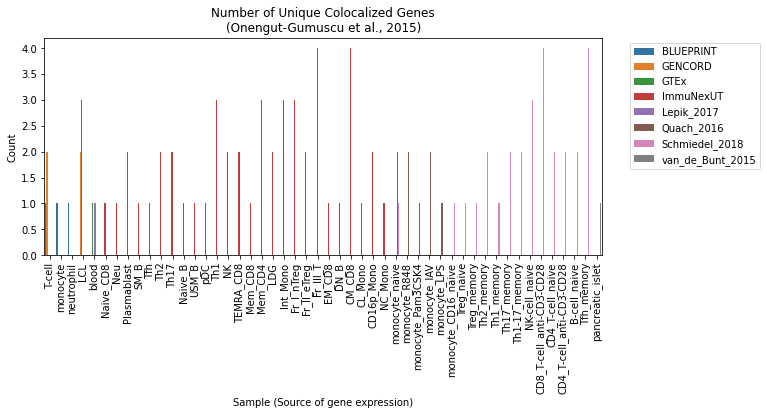

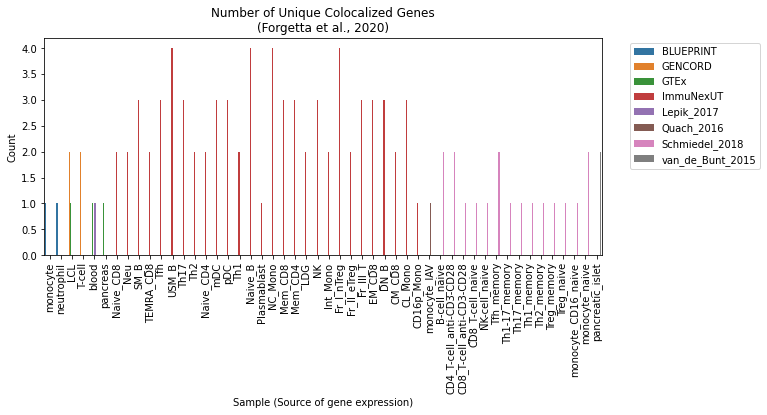

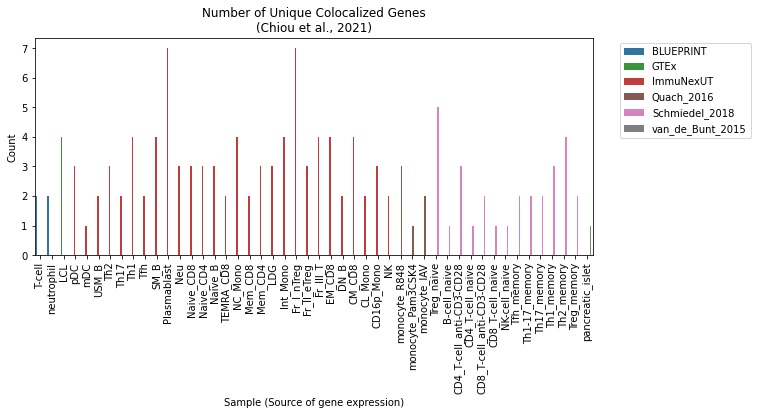

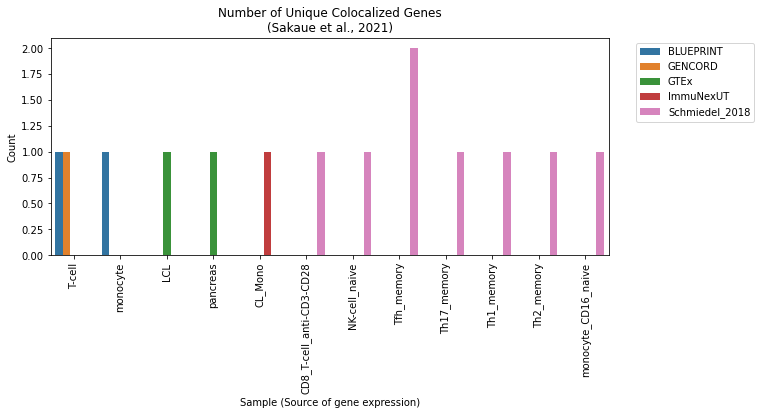

In [141]:
for gwas_source, gwas_summary in uniq_genes_per_sample.groupby('gwas_source'):
        
    fig, ax = plt.subplots(figsize=(10,4))
    
    # Draw a nested barplot by species and sex
    gwas_summary.sort_values('eqtl_source', inplace=True)
    g = sns.barplot(data=gwas_summary,
                x="ge_source", y="genename",
                hue='eqtl_source', palette=eqtl_colors, ax=ax)

    # move the legend
    ax.legend(bbox_to_anchor=(1.04,1), loc="upper left")
    

    for x in g.get_xticklabels():
        x.set_rotation(90)

    gwas_authorship = gwas_samplesheet.loc[gwas_source, 'authorship']    
    g.set_title('Number of Unique Colocalized Genes\n({})'.format(gwas_authorship))
    g.set_xlabel('Sample (Source of gene expression)')
    g.set_ylabel('Count')

In [142]:
# find the uniq snps
uniq_snps_per_samples = t1d_data.groupby(['gwas_source', 'eqtl_source', 'ge_source']).rsid.nunique().reset_index()

### Table for the number of unique genes and snps per colocalization analyses

In [143]:
# concat the two tables
uniq_summary = uniq_genes_per_sample.merge(uniq_snps_per_samples)
uniq_summary.columns = ['gwas', 'eqtl', 'ge', 'Unique # Genes', 'Unique # SNPs']

In [144]:
pd.set_option('display.max_rows', 100) 
display(uniq_summary.sort_values(['gwas', 'Unique # SNPs'], ascending=False))
pd.set_option('display.max_rows', 20) 

,gwas,eqtl,ge,Unique # Genes,Unique # SNPs
162,T1D_34594039_GCST90018925,Schmiedel_2018,Tfh_memory,2,2
154,T1D_34594039_GCST90018925,BLUEPRINT,T-cell,1,1
155,T1D_34594039_GCST90018925,BLUEPRINT,monocyte,1,1
156,T1D_34594039_GCST90018925,GENCORD,T-cell,1,1
157,T1D_34594039_GCST90018925,GTEx,LCL,1,1
...,...,...,...,...,...
49,T1D_25751624,Schmiedel_2018,Treg_memory,1,1
50,T1D_25751624,Schmiedel_2018,Treg_naive,1,1
51,T1D_25751624,Schmiedel_2018,monocyte_CD16_naive,1,1
52,T1D_25751624,Schmiedel_2018,monocyte_naive,1,1


### Table for the number snps per gene

In [145]:
# find the uniq snps
uniq_snps_per_genes = t1d_data.groupby(['gwas_source', 'eqtl_source', 'ge_source', 'gene_id'])

In [146]:
uniq_snps_per_genes = uniq_snps_per_genes.rsid.nunique().reset_index()

In [147]:
uniq_snps_per_genes.sort_values('rsid', ascending=False)

,gwas_source,eqtl_source,ge_source,gene_id,rsid
132,T1D_32005708,ImmuNexUT,Mem_CD4,ENSG00000198270,2
112,T1D_32005708,ImmuNexUT,DN_B,ENSG00000111300,2
230,T1D_34012112_Gaulton,ImmuNexUT,Fr_II_eTreg,ENSG00000246223,1
237,T1D_34012112_Gaulton,ImmuNexUT,Fr_I_nTreg,ENSG00000235945,1
236,T1D_34012112_Gaulton,ImmuNexUT,Fr_I_nTreg,ENSG00000206052,1
...,...,...,...,...,...
115,T1D_32005708,ImmuNexUT,EM_CD8,ENSG00000197728,1
114,T1D_32005708,ImmuNexUT,DN_B,ENSG00000197728,1
113,T1D_32005708,ImmuNexUT,DN_B,ENSG00000134460,1
111,T1D_32005708,ImmuNexUT,CM_CD8,ENSG00000198270,1


## Summarizing the Unique Genes Combined Across all Colocalization Analyses

In [148]:
# construct a table of unique genes 
gene_uniq_summary = t1d_data.drop_duplicates(['gwas_source', 'eqtl_source', 'ge_source', 'genename']).genename.value_counts()
gene_uniq_summary = gene_uniq_summary.to_frame()
gene_uniq_summary.sort_values('genename', ascending=False, inplace=True)
gene_uniq_summary.columns = ['Number of Unique Colocalizations per Gene in ALL Studies']

print('There are {} unique genes in the whole dataset.'.format(gene_uniq_summary.shape[0]))

# display this table
pd.set_option('display.max_rows', gene_uniq_summary.shape[0]) 
display(gene_uniq_summary)
pd.set_option('display.max_rows', 20) 

There are 141 unique genes in the whole dataset.


,Number of Unique Colocalizations per Gene in ALL Studies
DOK6,39
RPS26,37
TMPRSS3,19
TMEM116,13
AC068254.1,7
IL2RA,6
AC016747.1,6
PUS10,6
ACTA2,4
AC016747.2,4


In [149]:
msg = 'The number of genes across all colocalization analyses is: {}'.format(gene_uniq_summary.shape[0])
print(msg)

The number of genes across all colocalization analyses is: 141


In [150]:
# save an enrichr file 
enrichr_fn = os.path.join(outdir, 'enrichr.input.txt')
with open(enrichr_fn, 'w') as fw:
    for x in sorted(gene_uniq_summary.index.tolist()):
        print(x, file=fw)
        print(x)

ABCG1
AC002543.1
AC008063.1
AC008063.2
AC010733.1
AC016747.1
AC016747.2
AC016747.3
AC021205.3
AC027228.1
AC063965.1
AC068254.1
AC091196.1
AC091563.1
ACTA2
ADAM1B
AKR1C4
AL096678.1
AL121787.1
AL132996.1
AL133370.1
AL133445.2
AL137186.1
AL137779.2
AL137856.1
AL157394.1
AL157394.2
AL157395.1
AL157871.5
AL163932.1
AL354760.1
AL354977.2
AL355303.1
AL359317.1
AL513548.4
ALDH2
ANKRD22
ANKRD6
AP001610.1
AP001625.2
AP005131.7
AP005137.2
ARMH2
ASB13
BACH2
BBS12
BBS7
BCL11A
BEGAIN
BTN2A2
BTN3A1
BTN3A2
C11orf21
C1QTNF6
C2CD2
C2orf74
CACHD1
CBS
CD226
CENPW
CFL1P1
CTLA4
DEGS2
DOK6
DPP4
DSCC1
DUSP22
FGF2
FIGNL1
GABRR2
GLIS3
GMNN
GPLD1
GPN3
HIST1H1A
HIST1H1PS1
HIST1H2AE
HIST1H2BG
HIST1H2BH
HIST1H3D
HIST1H4B
HIST1H4E
HUS1B
IL2RA
ITPR3
KCNQ1-AS1
LINC00863
LINC01031
LINC01550
LINC02285
LINC02320
LINC02356
LINC02561
LINC02648
LIPM
LSM8
MAGI3
MAP3K7
MAPKAPK5
MAPKAPK5-AS1
NAA25
NDUFV3
NONOP2
NPIPB15
NUDT6
PAPOLG
PAPSS2
PEX13
PGM1
PHETA1
PKNOX1
PM20D2
PRDM15
PRKCQ
PRKCQ-AS1
PTPN22
PUS10
RBM17
REL
RFX3
RGS1
R

### Quick Dive into Treg Naive

In [151]:
treg = t1d_data.loc[t1d_data['ge_source'] == 'Treg_naive', :]
treg.sort_values(['chr', 'pos'], inplace=True)

/mnt/BioHome/jreyna/software/anaconda3/envs/hic_tls/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [152]:
treg[major_cols]

,chr,pos,rsid,varid,genename,ppH4,sg_dist,eqtl_pval,eqtl_fdr,eqtl_slope,eqtl_slope_se,gwas_slope,gwas_slope_se,gwas_pval,gwas_source,eqtl_source,ge_source,gene_id
334,chr1,113285485,rs773560,1:113285485:G:A,AL137856.1,0.978083,526894,2.323010e-02,0.632393,-0.438205,0.004354,0.168861,0.015663,4.230000e-27,T1D_34012112_Gaulton,Schmiedel_2018,Treg_naive,ENSG00000231128
331,chr1,192546719,rs10801128,1:192546719:A:G,RGS1,0.865499,29044,1.363810e-02,0.541238,0.225144,0.016133,0.096073,0.015681,8.980000e-10,T1D_34012112_Gaulton,Schmiedel_2018,Treg_naive,ENSG00000090104
198,chr10,6056861,rs706779,10:6056861:T:C,AL157395.1,0.817264,145832,1.118810e-02,0.506346,0.313304,0.007850,-0.166800,0.023800,2.250000e-12,T1D_32005708,Schmiedel_2018,Treg_naive,ENSG00000213994
335,chr14,98019683,rs922406,14:98019683:T:C,AL163932.1,0.787636,185460,9.708230e-03,0.481031,-0.493646,0.002879,-0.092793,0.015229,1.110000e-09,T1D_34012112_Gaulton,Schmiedel_2018,Treg_naive,ENSG00000259097
93,chr18,69858621,rs3018275,18:69858621:C:T,DOK6,0.842460,457733,1.243620e-07,0.000112,-0.527773,0.002469,0.120978,0.017997,1.789737e-11,T1D_25751624,Schmiedel_2018,Treg_naive,ENSG00000206052
333,chr18,69858621,rs3018275,18:69858621:C:T,DOK6,0.841050,457733,1.243620e-07,0.000112,-0.527773,0.002469,-0.102841,0.014026,2.260000e-13,T1D_34012112_Gaulton,Schmiedel_2018,Treg_naive,ENSG00000206052
332,chr2,60422008,rs12997266,2:60422008:G:A,AC016747.2,0.754330,740097,2.485170e-02,0.643440,-0.368777,0.009128,-0.087489,0.014351,1.090000e-09,T1D_34012112_Gaulton,Schmiedel_2018,Treg_naive,ENSG00000271889


## Quick Dive into GLIS3

Very lowly expressed according to DICE: https://dice-database.org/genes/GLIS3 and eQTL FDR is not significant. 

In [153]:
t1d_data.loc[t1d_data['genename'] == 'GLIS3', major_cols]

,chr,pos,rsid,varid,genename,ppH4,sg_dist,eqtl_pval,eqtl_fdr,eqtl_slope,eqtl_slope_se,gwas_slope,gwas_slope_se,gwas_pval,gwas_source,eqtl_source,ge_source,gene_id
206,chr9,4290823,rs6476839,9:4290823:A:T,GLIS3,0.809271,57569,0.010269,0.242092,-0.338403,0.006585,0.123270,0.014153,3.040000e-18,T1D_34012112_Gaulton,BLUEPRINT,neutrophil,ENSG00000107249
301,chr9,4296430,rs10814917,9:4296430:A:G,GLIS3,0.759110,51962,0.057347,0.713889,-0.274822,0.012701,-0.119714,0.013994,1.180000e-17,T1D_34012112_Gaulton,Quach_2016,monocyte_IAV,ENSG00000107249
303,chr9,4296430,rs10814917,9:4296430:A:G,GLIS3,0.776345,51962,0.027644,0.568634,-0.325938,0.008901,-0.119714,0.013994,1.180000e-17,T1D_34012112_Gaulton,Quach_2016,monocyte_Pam3CSK4,ENSG00000107249
306,chr9,4282536,rs4380994,9:4282536:A:G,GLIS3,0.806803,65856,0.006440,0.336787,-0.407677,0.005361,-0.121582,0.013995,3.710000e-18,T1D_34012112_Gaulton,Quach_2016,monocyte_R848,ENSG00000107249


### Quick dive into COLOC for analyses

In [161]:
select_cells = ['Plasmablast', 'Fr_I_nTreg']
select_data = t1d_data.loc[(t1d_data.gwas_source == 'T1D_34012112_Gaulton') & 
             (t1d_data.eqtl_source == 'ImmuNexUT') &
             (t1d_data.ge_source.isin(select_cells))]

In [162]:
select_data.loc[select_data.ge_source == 'Fr_I_nTreg']

,chr,pos,rsid,varid,genename,ppH4,sg_dist,eqtl_pval,eqtl_fdr,eqtl_slope,eqtl_slope_se,gwas_slope,gwas_slope_se,gwas_pval,gwas_source,eqtl_source,ge_source,gene_id
234,chr9,4292083,rs10758593,9:4292083:G:A,SPATA6L,0.775475,374591,2.811760e-03,1.527113e-01,0.203818,0.018893,0.124426,0.014135,1.330000e-18,T1D_34012112_Gaulton,ImmuNexUT,Fr_I_nTreg,ENSG00000106686
235,chr2,60406328,rs13035645,2:60406328:T:A,AC016747.3,0.894993,793651,3.547170e-02,5.474464e-01,0.697347,0.003146,-0.087644,0.015296,1.010000e-08,T1D_34012112_Gaulton,ImmuNexUT,Fr_I_nTreg,ENSG00000273302
236,chr7,117462031,rs177069,7:117462031:A:G,AC002543.1,0.777563,585655,2.386220e-01,8.590260e-01,-0.435143,0.008709,0.117393,0.016117,3.250000e-13,T1D_34012112_Gaulton,ImmuNexUT,Fr_I_nTreg,ENSG00000235945
237,chr18,69866164,rs1790932,18:69866164:C:T,DOK6,0.892936,465109,1.591880e-06,3.157811e-04,-0.268596,0.010673,-0.102240,0.013995,2.760000e-13,T1D_34012112_Gaulton,ImmuNexUT,Fr_I_nTreg,ENSG00000206052
238,chr14,100841366,rs34337125,14:100841366:G:A,BEGAIN,0.848185,253953,1.486410e-02,3.879238e-01,-0.224439,0.022822,-0.120547,0.014814,4.040000e-16,T1D_34012112_Gaulton,ImmuNexUT,Fr_I_nTreg,ENSG00000183092
239,chr1,113285485,rs773560,1:113285485:G:A,MAGI3,0.979196,105264,1.936030e-02,4.354628e-01,0.184124,0.026659,0.168861,0.015663,4.230000e-27,T1D_34012112_Gaulton,ImmuNexUT,Fr_I_nTreg,ENSG00000081026
240,chr21,42405613,rs9981624,21:42405613:G:C,TMPRSS3,0.908288,8767,9.030490e-11,4.013683e-08,0.710931,0.002507,0.147044,0.014822,3.390000e-23,T1D_34012112_Gaulton,ImmuNexUT,Fr_I_nTreg,ENSG00000160183


In [163]:
select_data.loc[select_data.ge_source == 'Plasmablast']

,chr,pos,rsid,varid,genename,ppH4,sg_dist,eqtl_pval,eqtl_fdr,eqtl_slope,eqtl_slope_se,gwas_slope,gwas_slope_se,gwas_pval,gwas_source,eqtl_source,ge_source,gene_id
271,chr1,63657608,rs11208260,1:63657608:G:A,PGM1,0.855703,64332,1.720090e-08,2.605504e-06,-0.308641,0.010007,0.111083,0.017211,1.090000e-10,T1D_34012112_Gaulton,ImmuNexUT,Plasmablast,ENSG00000079739
272,chr2,60406328,rs13035645,2:60406328:T:A,PAPOLG,0.911215,349902,5.009830e-02,5.144423e-01,0.281216,0.022450,-0.087644,0.015296,1.010000e-08,T1D_34012112_Gaulton,ImmuNexUT,Plasmablast,ENSG00000115421
273,chr22,37185445,rs229527,22:37185445:C:A,C1QTNF6,0.795971,13940,6.898180e-23,4.903488e-20,-0.588069,0.001953,0.104077,0.014138,1.820000e-13,T1D_34012112_Gaulton,ImmuNexUT,Plasmablast,ENSG00000133466
274,chr9,4290823,rs6476839,9:4290823:A:T,RFX3,0.791872,764819,1.877290e-04,1.147042e-02,0.211862,0.017420,0.123270,0.014153,3.040000e-18,T1D_34012112_Gaulton,ImmuNexUT,Plasmablast,ENSG00000080298
275,chr12,112412095,rs7300285,12:112412095:G:A,TMEM116,0.973973,398910,8.866680e-04,4.142134e-02,0.356715,0.008699,-0.126231,0.014906,2.480000e-17,T1D_34012112_Gaulton,ImmuNexUT,Plasmablast,ENSG00000198270
276,chr1,113285485,rs773560,1:113285485:G:A,SLC16A1-AS1,0.972030,329070,1.377070e-03,5.862208e-02,0.181735,0.027376,0.168861,0.015663,4.230000e-27,T1D_34012112_Gaulton,ImmuNexUT,Plasmablast,ENSG00000226419
277,chr21,42415901,rs80054410,21:42415901:T:C,UMODL1,0.881957,352942,1.406260e-01,7.162503e-01,0.245636,0.027948,0.140279,0.014471,3.200000e-22,T1D_34012112_Gaulton,ImmuNexUT,Plasmablast,ENSG00000177398


## Saving genes for excel analysis 

In [32]:
# find the unique SNPs
uniq_snps_by_cells = t1d_data.groupby('ge_source').varid.nunique()
uniq_snps_by_cells = uniq_snps_by_cells.to_frame()

#find the unique genes 
uniq_genes_by_cells = t1d_data.groupby('ge_source').gene_id.nunique()
uniq_genes_by_cells = uniq_genes_by_cells.to_frame()

# merge
uniq_counts_by_cells = pd.merge(uniq_snps_by_cells, uniq_genes_by_cells, left_index=True, right_index=True)
uniq_counts_by_cells.columns = ['Number of Unique SNPs', 'Number of Unique Genes']
uniq_counts_by_cells.index.name = 'Cell Line'

In [33]:
# save the file
excel_analysis = os.path.join(outdir, 'Unique_Counts_By_Cell_Line.xlsx')
uniq_counts_by_cells.to_excel(excel_analysis, sheet_name='colocalization')

In [34]:
excel_analysis

'results/notebooks/colocalization_with_eqtl_catalogue/Unique_Counts_By_Cell_Line.xlsx'

#### Write the gene list as well

In [35]:
gh_list = t1d_data.gene_id.unique()
gh_fn = os.path.join(outdir, 'gene_list.txt')
with open(gh_fn, 'w') as fw:
    for x in gh_list:
        fw.write('{}\n'.format(x))

#### Get the unique genes per cell type 

In [36]:
genes_by_cell = t1d_data[['ge_source', 'gene_id']].drop_duplicates()
genes_by_cell.sort_values(['ge_source', 'gene_id'], inplace=True)
genes_by_cell['source'] = 'colocalization'
genes_by_cell.columns = ['cline', 'geneid', 'source']
fn = os.path.join(outdir, 'genes_by_cell.xlsx')
genes_by_cell.to_excel(fn, index=False)

In [37]:
genes_by_cell

,cline,geneid,source
68,B-cell_naive,ENSG00000138685,colocalization
69,B-cell_naive,ENSG00000170677,colocalization
184,B-cell_naive,ENSG00000197728,colocalization
185,B-cell_naive,ENSG00000237943,colocalization
307,B-cell_naive,ENSG00000258837,colocalization
...,...,...,...
341,pancreas,ENSG00000285571,colocalization
96,pancreatic_islet,ENSG00000160181,colocalization
202,pancreatic_islet,ENSG00000197728,colocalization
203,pancreatic_islet,ENSG00000198610,colocalization
